In [1]:
# MO444-A 2s/2017 - Third assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold

def loadIDs():
    lines=[]
    with open('documents/ids', "r") as f:
        lines = f.read().splitlines()
    return np.asarray(lines)

def loadFeatures():
    features = pd.read_csv('documents/data.csv', sep=',', header=None)
    return features.values

def loadDocument(docID):
    data = None
    with open('documents/docs/' + docID, 'r') as docfile:
        data = docfile.read().replace('\n', '')
    return data

def runKFoldClustering(model, data):
    random_state = np.random.RandomState(1)
    k5_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    costs = []
    for train_index, validation_index in k5_fold.split(data):
        train_data, validation_data = data[train_index], data[validation_index]
        model.fit(train_data)
        model.predict(validation_data)
        costs.append(model.inertia_)
    return np.mean(costs), np.std(costs)


In [2]:
ids = loadIDs()
print('IDs shape: {}'.format(ids.shape))

data = loadFeatures()
print('Data shape: {}'.format(data.shape))

IDs shape: (19924,)
Data shape: (19924, 2209)


In [3]:
# Let's look at the 5 first instances of the IDs
print(ids[0:5])

['832e15531654188fa0b951faa5f68540dfb1ca5a'
 'aa5163928a6edfd3bf69fd11fe763aacecf4602d'
 'e886703afff0c70d6598bcae0c2d69a5a237807f'
 'c1ea507b177b2e1673ce7a576057f91b75ae9d29'
 'bbf73405c85d22702fafc1c0916e8f713810ff8d']


In [4]:
# Now, let's have a look at the 5 first instances of the data (bag-of-words feature vectors)
data_frame = pd.DataFrame(data)
data_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2199,2200,2201,2202,2203,2204,2205,2206,2207,2208
0,0.077257,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.055755,0.0,0.0
2,0.042250,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.093693,0.0,0.099296,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.069105,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.036811,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.041917,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [5]:
# Checking the value ranges
print('Min. value: {}'.format(np.min(data.flatten())))
print('Max. value: {}'.format(np.max(data.flatten())))

# Let's scale and normalize the data
data = scale(data)

normalizer = Normalizer()
normalizer = normalizer.fit(data)

data = normalizer.transform(data)

Min. value: 0.0
Max. value: 0.999901


2 clusters: Cost 15839.92 ± 0.76
4 clusters: Cost 15756.58 ± 5.40
8 clusters: Cost 15602.82 ±14.17
16 clusters: Cost 15409.90 ±11.12
32 clusters: Cost 15100.33 ±24.79
64 clusters: Cost 14667.04 ±12.01
128 clusters: Cost 14210.46 ±20.63
256 clusters: Cost 13816.03 ±42.99
512 clusters: Cost 13738.17 ±150.86


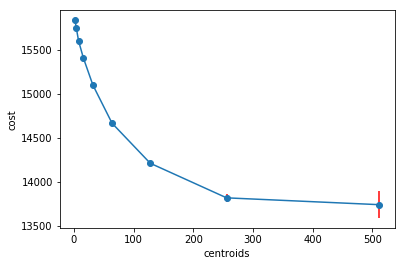

In [6]:
# Attempting Mini-Batch K means with some different number of centroids.
kmeans, costs, costs_sd = [], [], []
num_centroids = [2, 4, 8, 16, 32, 64, 128, 256, 512]
for i in num_centroids:
    model = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=1)
    cost_mean, cost_sd = runKFoldClustering(model, data)
    kmeans.append(model)
    costs.append(cost_mean)
    costs_sd.append(cost_sd)
    print '%d clusters: Cost %5.2f ±%5.2f' % (i, cost_mean, cost_sd)

# Plot an elbow curve.
plt.plot(color='blue', marker='o')
plt.errorbar(num_centroids, costs, yerr=costs_sd, 
             fmt='-o', ecolor='r', capthick=2)
plt.xlabel('centroids')
plt.ylabel('cost')
plt.show()

In [8]:
# Check the silhouette scores.
start_time = datetime.now()
sil_avgs, sil_avgs_centroids = [], []
for i in range(len(kmeans)):
    labels = kmeans[i].predict(data)
    sil_avg = silhouette_score(data, labels)
    print('centroids: %d, silhouette average: %f' % (kmeans[i].n_clusters, sil_avg))
    sil_avgs.append(sil_avg)
    sil_avgs_centroids.append(kmeans[i].n_clusters)

print('Elapsed time: {}'.format(datetime.now() - start_time))

centroids: 2, silhouette average: 0.006241
centroids: 4, silhouette average: 0.004755
centroids: 8, silhouette average: 0.007339
centroids: 16, silhouette average: 0.010163
centroids: 32, silhouette average: 0.015340
centroids: 64, silhouette average: 0.019948
centroids: 128, silhouette average: 0.021235
centroids: 256, silhouette average: -0.006790
centroids: 512, silhouette average: -0.031887
Elapsed time: 0:04:09.195946


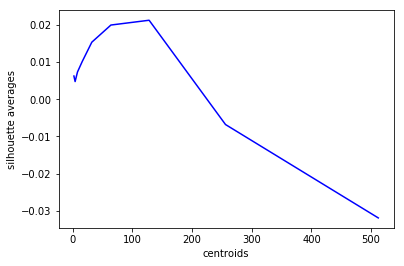

In [9]:
# Plot the silhouette averages
plt.plot(sil_avgs_centroids, sil_avgs, color='blue')
plt.xlabel('centroids')
plt.ylabel('silhouette averages')
plt.show()

In [16]:
# Chosen number of centroids: 128
chosen_model = kmeans[6]
chosen_model_labels = chosen_model.predict(data)

In [17]:
# Let's check three sample groups, their medoid documents, and two other closer documents.
for i in [32, 64, 96]:
    print('Group: %d' % i)
    center = chosen_model.cluster_centers_[i]
    group_points = data[chosen_model_labels == i]
    group_doc_ids = ids[chosen_model_labels == i]

    # Let's find the medoid and their closest points
    distancesMatrix = pairwise_distances(group_points, metric='euclidean')
    closest_to_medoid_indexes = np.argsort(distancesMatrix.sum(axis=0))
    medoid_index = closest_to_medoid_indexes[0]

    print(' - Medoid doc: {}'.format(group_doc_ids[medoid_index]))
    print(loadDocument(group_doc_ids[medoid_index]))
    print(' - ')
    print(' -- Closest to medoid doc: {}'.format(group_doc_ids[closest_to_medoid_indexes[1]]))
    print(loadDocument(group_doc_ids[closest_to_medoid_indexes[1]]))
    print(' -- ')
    print(' --- Second closest to medoid doc: {}'.format(group_doc_ids[closest_to_medoid_indexes[2]]))
    print(loadDocument(group_doc_ids[closest_to_medoid_indexes[2]]))
    print(' --- ')

Group: 32
 - Medoid doc: c6b7094f1ced7b2a668f4b6fad719d2dddc7aa15
Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!doc.ic.ac.uk!dundee.ac.uk!cardhu!dwestnerFrom: dwestner@cardhu.mcs.dundee.ac.uk (Dominik Westner)Newsgroups: comp.graphicsSubject: need a viewer for gl filesDate: 19 Apr 1993 11:42:10 GMTOrganization: Maths & C.S. Dept., Dundee University, Scotland, UKLines: 10Message-ID: <1qu36i$kh7@dux.dundee.ac.uk>NNTP-Posting-Host: cardhu.mcs.dundee.ac.ukX-Newsreader: TIN [version 1.1 PL9]Hi, the subject says it all. Is there a PD viewer for gl files (for X)?ThanksDominik
 - 
 -- Closest to medoid doc: a25d9024e3cc3792907f64dc5be2caea8a48fb73
Newsgroups: alt.atheismPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!pacific.mps.ohio-state.edu!zaphod.mps.ohio-state.edu!moe.ksu.ksu.edu!osuunx.ucc.okstate.edu!constellation!darkside!okcforum.osrhe.edu!bilFrom: bil@okcforum.osrhe.edu (B